# Brain Tumor Segmentation using Attention 2D U-NET Architecture

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Dataset/archive.zip



Archive:  /content/drive/MyDrive/Dataset/archive.zip
  inflating: MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_flair.nii  
  inflating: MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_seg.nii  
  inflating: MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t1.nii  
  inflating: MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t1ce.nii  
  inflating: MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t2.nii  
  inflating: MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_11_1/Brats18_2013_11_1_flair.nii  
  inflating: MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_11_1/Brats18_2013_11_1_seg.nii  
  inflating: MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_11_1/Brats18_2013_11_1_t1.nii  
  inflating: MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_11_1/Brats18_2013_11_1_t1ce.nii  
  inflating: MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_11_1/Brats18_2013_11_1_t2.n

In [3]:
pip install nilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 43.8 MB/s eta 0:00:00


In [4]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# Segment Classes and Volume Configuration:

In [5]:
# DEFINE seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE - RED
    2 : 'EDEMA',  # Green
    3 : 'ENHANCING' # original 4 -> converted into 3 later, Yellow
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include

IMG_SIZE=128

# Loading Test images and masks

In [6]:
TRAIN_DATASET_PATH = '/content/MICCAI_BraTS_2018_Data_Training/HGG'


In [7]:
# !ls $TRAIN_DATASET_PATH


In [8]:
nSample = os.listdir(TRAIN_DATASET_PATH + '/Brats18_2013_13_1')
nSample

['Brats18_2013_13_1_flair.nii',
 'Brats18_2013_13_1_t1.nii',
 'Brats18_2013_13_1_t1ce.nii',
 'Brats18_2013_13_1_t2.nii',
 'Brats18_2013_13_1_seg.nii']

In [9]:
test_image_flair=nib.load(TRAIN_DATASET_PATH + '/Brats18_2013_13_1/Brats18_2013_13_1_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + '/Brats18_2013_13_1/Brats18_2013_13_1_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + '/Brats18_2013_13_1/Brats18_2013_13_1_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + '/Brats18_2013_13_1//Brats18_2013_13_1_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + '/Brats18_2013_13_1/Brats18_2013_13_1_seg.nii').get_fdata()

# Displaying Test images and masks

Text(0.5, 1.0, 'Mask')

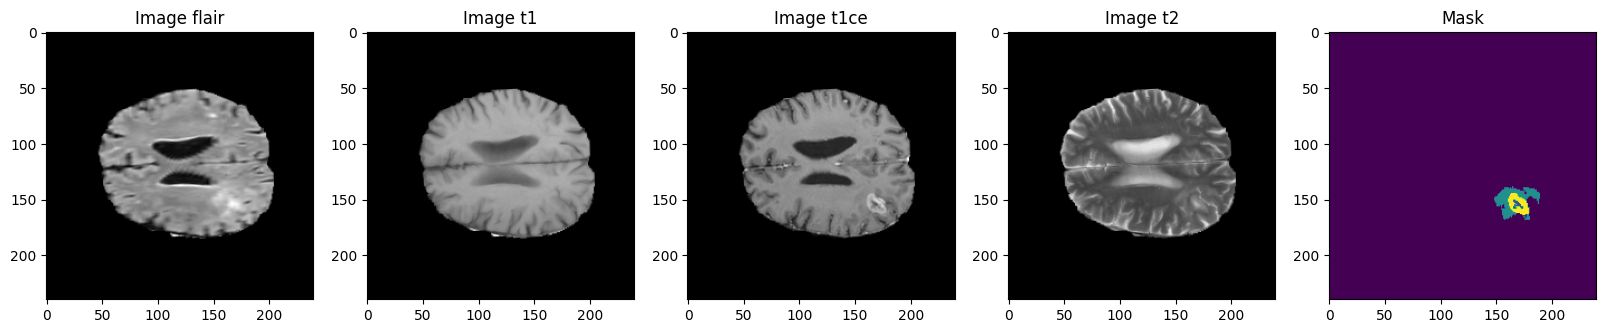

In [10]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

# Displaying Tranformed images

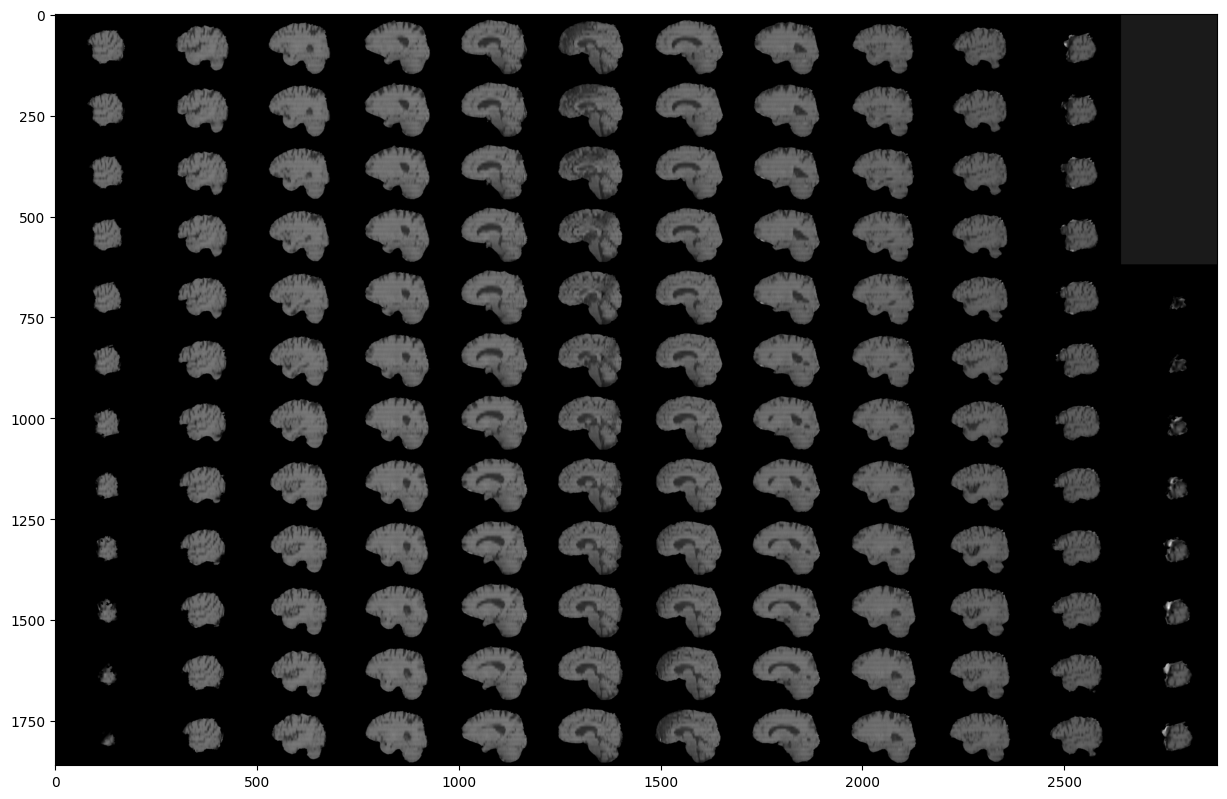

In [11]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

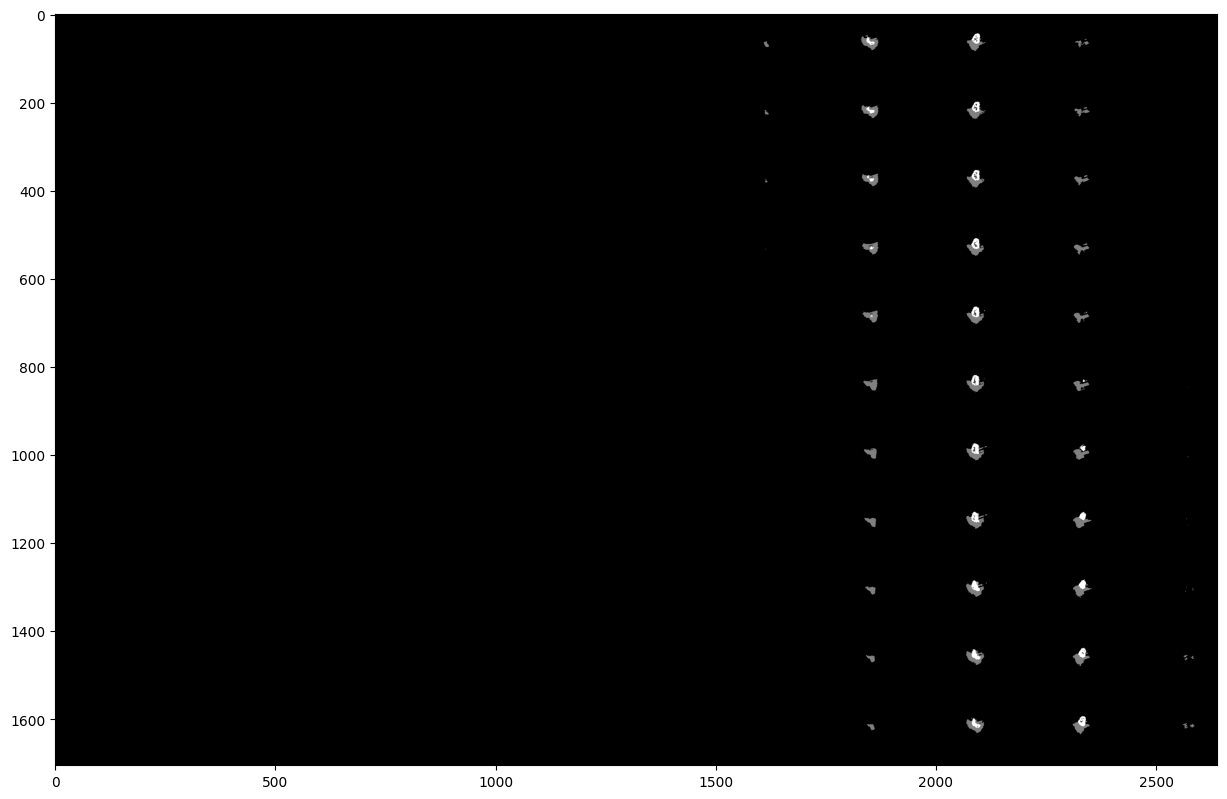

In [12]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

# Visualizing Brain images and masks

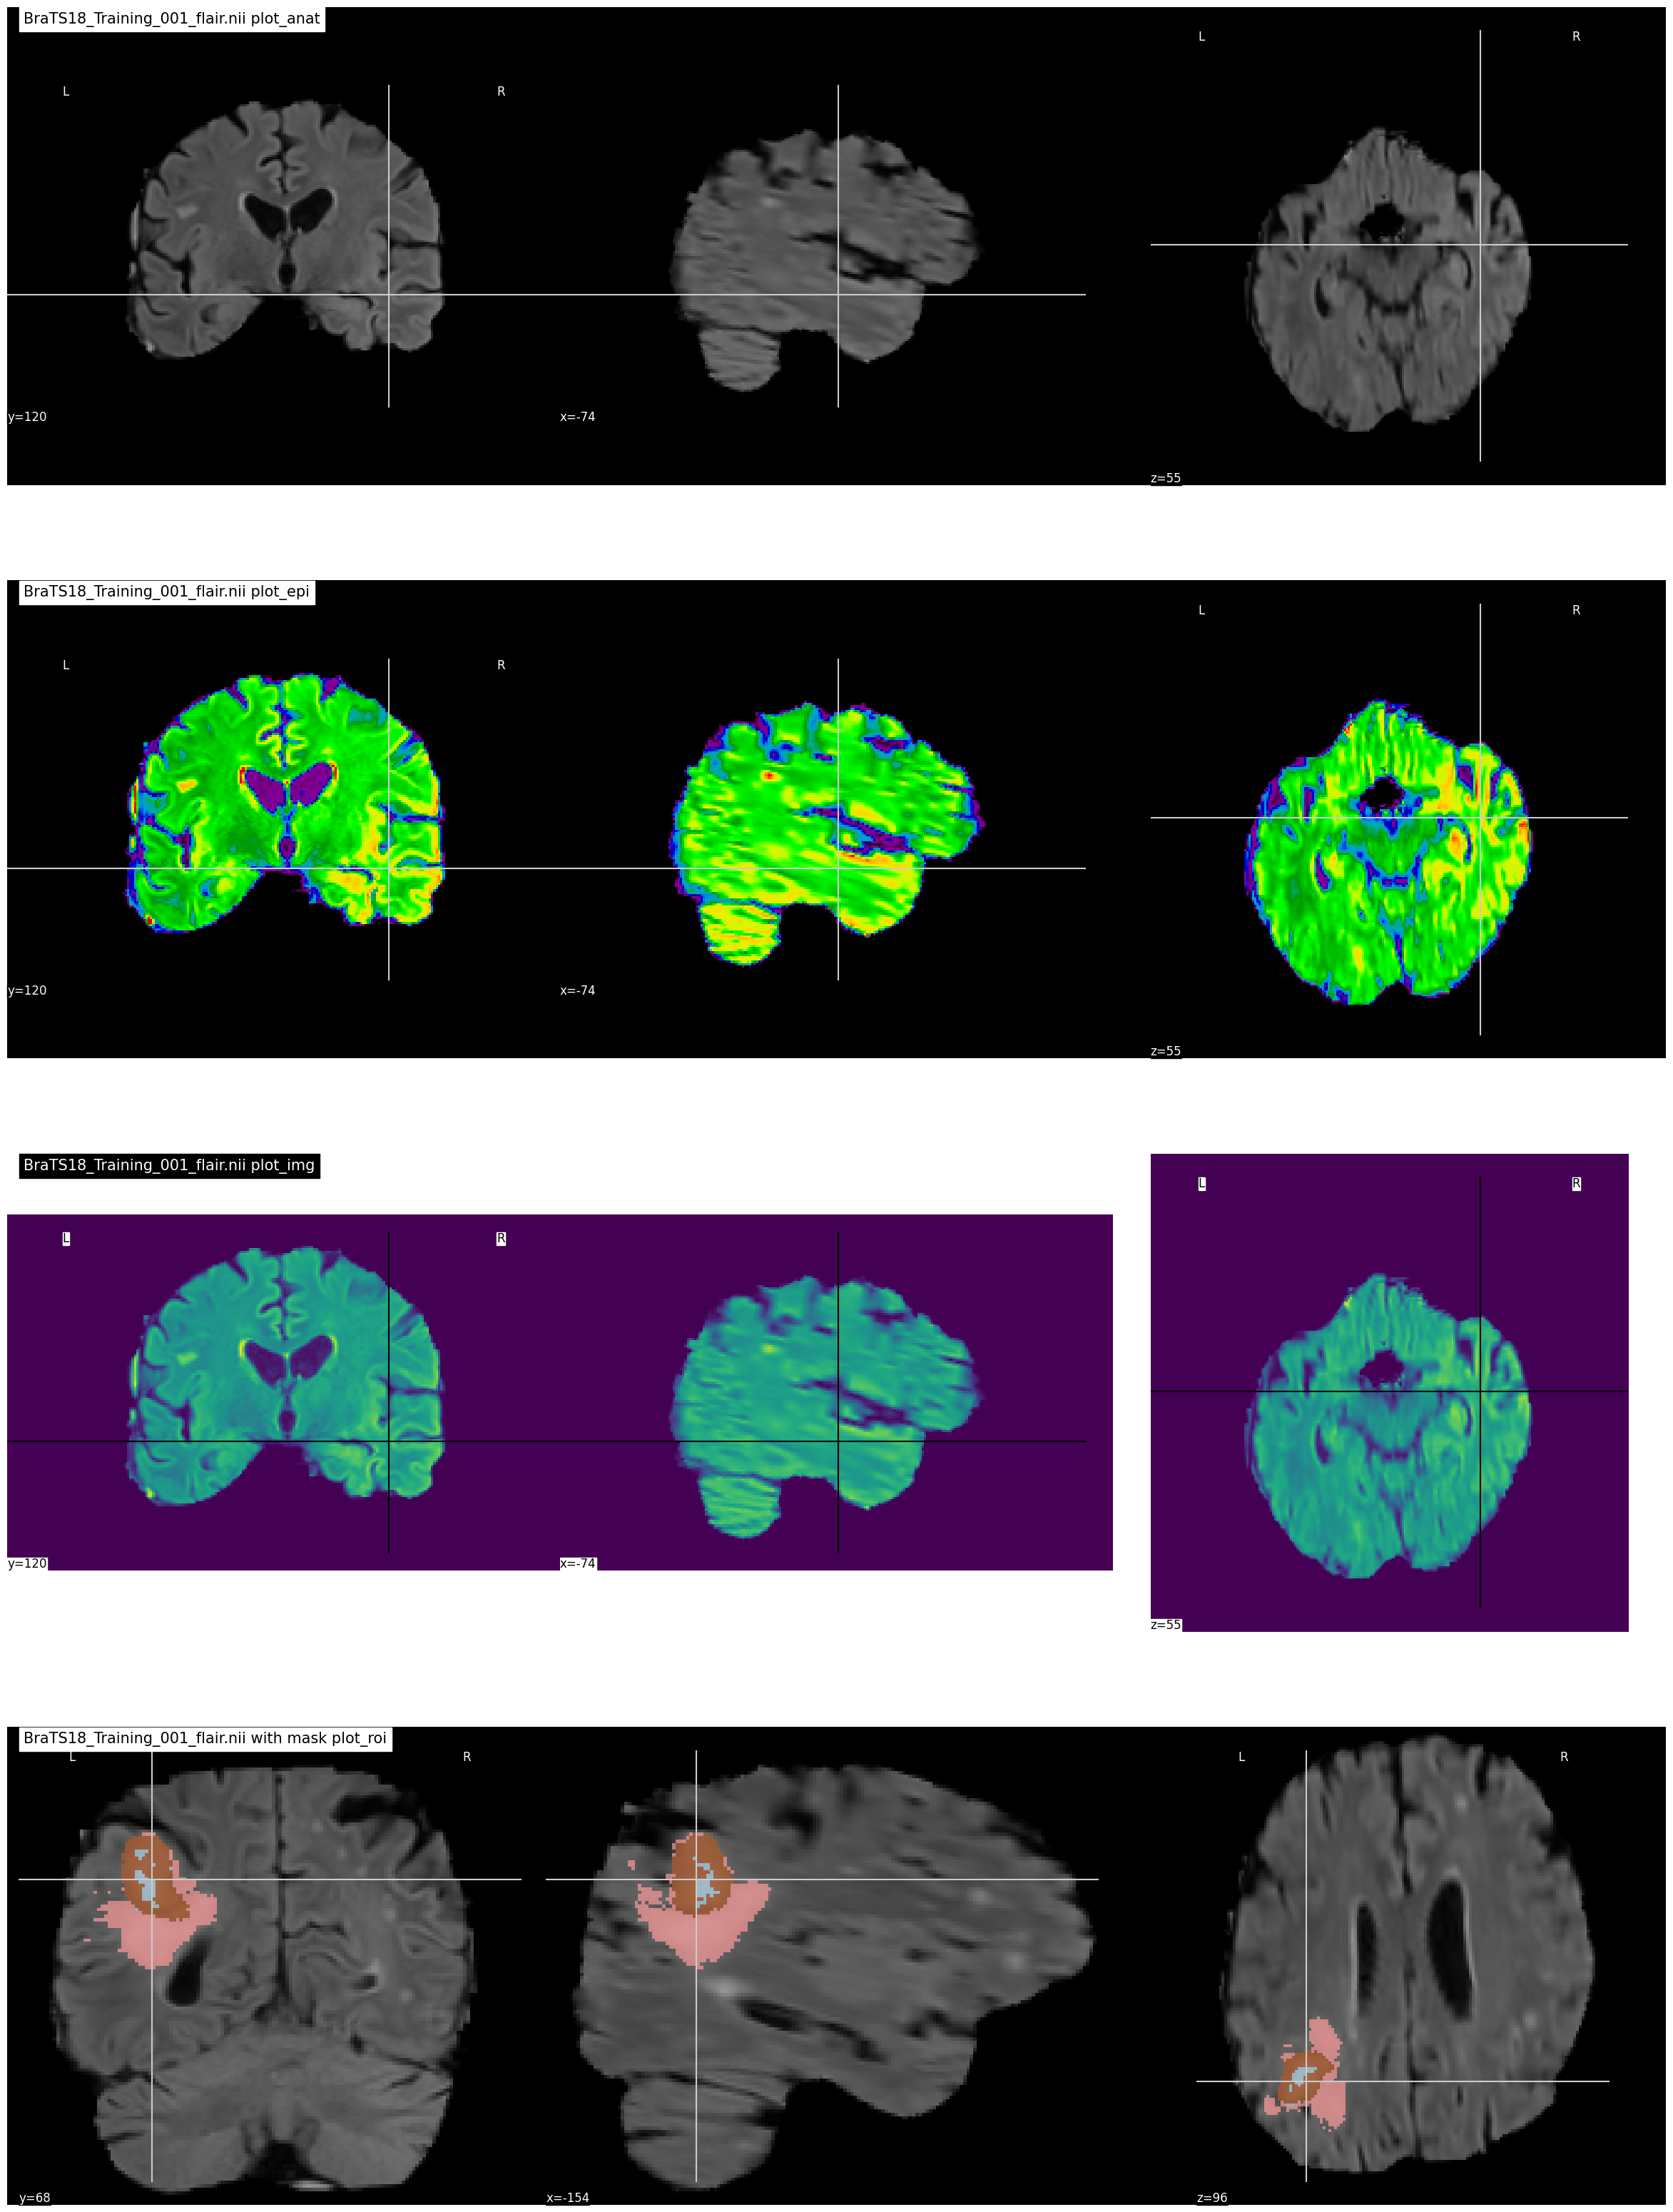

In [13]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + '/Brats18_2013_13_1/Brats18_2013_13_1_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + '/Brats18_2013_13_1/Brats18_2013_13_1_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS18_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS18_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS18_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask,
               title='BraTS18_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg,
               axes=axes[3], cmap='Paired')

plt.show()

# Performance metrics

In [14]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss

    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss



# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [15]:
# from tensorflow.keras.layers import Conv3D, MaxPooling3D, UpSampling3D, concatenate, Dropout, Input
# from tensorflow.keras.models import Model

# def build_3d_unet(inputs, ker_init, dropout):
#     conv1 = Conv3D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
#     conv1 = Conv3D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)

#     pool = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
#     conv = Conv3D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool)
#     conv = Conv3D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv)

#     pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv)
#     conv2 = Conv3D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
#     conv2 = Conv3D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)

#     pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
#     conv3 = Conv3D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
#     conv3 = Conv3D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)

#     pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
#     conv5 = Conv3D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
#     conv5 = Conv3D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
#     drop5 = Dropout(dropout)(conv5)

#     up7 = Conv3D(256, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(drop5))
#     merge7 = concatenate([conv3, up7], axis=4)
#     conv7 = Conv3D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
#     conv7 = Conv3D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)

#     up8 = Conv3D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(conv7))
#     merge8 = concatenate([conv2, up8], axis=4)
#     conv8 = Conv3D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
#     conv8 = Conv3D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv8)

#     up9 = Conv3D(64, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(conv8))
#     merge9 = concatenate([conv, up9], axis=4)
#     conv9 = Conv3D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge9)
#     conv9 = Conv3D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv9)

#     up = Conv3D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(conv9))
#     merge = concatenate([conv1, up], axis=4)
#     conv = Conv3D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge)
#     conv = Conv3D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv)

#     conv10 = Conv3D(4, (1, 1, 1), activation='softmax')(conv)

#     return Model(inputs=inputs, outputs=conv10)

# IMG_SIZE = 64  # Adjust this as needed for your data
# input_layer = Input((IMG_SIZE, IMG_SIZE, IMG_SIZE, 2))  # Adjust the input shape for 3D data
# model = build_3d_unet(input_layer, 'he_normal', 0.2)


# Unet Architecture

In [16]:
# from tensorflow.keras.layers import Conv3D, MaxPooling3D, UpSampling3D, concatenate, Dropout, Input
# from tensorflow.keras.models import Model

# def attention_block_3d(x, g, inter_channel):
#     theta_x = Conv3D(inter_channel, (1, 1, 1), strides=(1, 1, 1), padding='same')(x)
#     phi_g = Conv3D(inter_channel, (1, 1, 1), strides=(1, 1, 1), padding='same')(g)
#     f = tf.keras.layers.Add()([theta_x, phi_g])
#     f = tf.keras.layers.Activation('relu')(f)
#     psi_f = Conv3D(1, (1, 1, 1), strides=(1, 1, 1), padding='same')(f)
#     rate = tf.keras.layers.Activation('sigmoid')(psi_f)
#     att_x = tf.keras.layers.Multiply()([x, rate])
#     return att_x

# def build_unet_with_attention_3d(inputs, ker_init, dropout):
#     conv1 = Conv3D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
#     conv1 = Conv3D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)
#     att1 = attention_block_3d(conv1, conv1, 16)

#     pool1 = MaxPooling3D(pool_size=(2, 2, 2))(att1)
#     conv2 = Conv3D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
#     conv2 = Conv3D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)
#     att2 = attention_block_3d(conv2, conv2, 32)

#     pool2 = MaxPooling3D(pool_size=(2, 2, 2))(att2)
#     conv3 = Conv3D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
#     conv3 = Conv3D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)
#     att3 = attention_block_3d(conv3, conv3, 64)

#     pool3 = MaxPooling3D(pool_size=(2, 2, 2))(att3)
#     conv4 = Conv3D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool3)
#     conv4 = Conv3D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv4)
#     att4 = attention_block_3d(conv4, conv4, 128)

#     pool4 = MaxPooling3D(pool_size=(2, 2, 2))(att4)
#     conv5 = Conv3D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
#     conv5 = Conv3D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
#     drop5 = Dropout(dropout)(conv5)

#     return drop5

# def build_decoder_3d(drop5, ker_init, dropout):
#     up6 = Conv3D(256, 2, activation='relu', padding='same', kernel_initializer=ker_init)(
#         UpSampling3D(size=(2, 2, 2))(drop5))
#     conv6 = Conv3D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(up6)
#     conv6 = Conv3D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv6)

#     up7 = Conv3D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init)(
#         UpSampling3D(size=(2, 2, 2))(conv6))
#     conv7 = Conv3D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(up7)
#     conv7 = Conv3D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)

#     up8 = Conv3D(64, 2, activation='relu', padding='same', kernel_initializer=ker_init)(
#         UpSampling3D(size=(2, 2, 2))(conv7))
#     conv8 = Conv3D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(up8)
#     conv8 = Conv3D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv8)

#     up9 = Conv3D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(
#         UpSampling3D(size=(2, 2, 2))(conv8))
#     conv9 = Conv3D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(up9)
#     conv9 = Conv3D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv9)

#     conv10 = Conv3D(4, (1, 1, 1), activation='softmax')(conv9)

#     return conv10

# IMG_SIZE = 64  # Adjust this as needed for your data
# input_layer = Input((IMG_SIZE, IMG_SIZE, IMG_SIZE, 2))  # Adjust the input shape for 3D data
# pool4 = build_unet_with_attention_3d(input_layer, 'he_normal', 0.2)
# output_layer = build_decoder_3d(pool4, 'he_normal', 0.2)

# model = Model(inputs=input_layer, outputs=output_layer)
# model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#               metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4)])


In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Input
from tensorflow.keras.models import Model

def attention_block_2d(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, (1, 1), strides=(1, 1), padding='same')(x)
    phi_g = Conv2D(inter_channel, (1, 1), strides=(1, 1), padding='same')(g)
    f = tf.keras.layers.Add()([theta_x, phi_g])
    f = tf.keras.layers.Activation('relu')(f)
    psi_f = Conv2D(1, (1, 1), strides=(1, 1), padding='same')(f)
    rate = tf.keras.layers.Activation('sigmoid')(psi_f)
    att_x = tf.keras.layers.Multiply()([x, rate])
    return att_x

def build_unet_with_attention(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)
    att1 = attention_block_2d(conv1, conv1, 16)

    pool1 = MaxPooling2D(pool_size=(2, 2))(att1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)
    att2 = attention_block_2d(conv2, conv2, 32)

    pool2 = MaxPooling2D(pool_size=(2, 2))(att2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)
    att3 = attention_block_2d(conv3, conv3, 64)

    pool3 = MaxPooling2D(pool_size=(2, 2))(att3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv4)
    att4 = attention_block_2d(conv4, conv4, 128)

    pool4 = MaxPooling2D(pool_size=(2, 2))(att4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    return drop5

def build_decoder(drop5, ker_init, dropout):
    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=ker_init)(
        UpSampling2D(size=(2, 2))(drop5))
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(up6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv6)

    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init)(
        UpSampling2D(size=(2, 2))(conv6))
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(up7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)

    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=ker_init)(
        UpSampling2D(size=(2, 2))(conv7))
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(up8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(
        UpSampling2D(size=(2, 2))(conv8))
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(up9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv9)

    conv10 = Conv2D(4, (1, 1), activation='softmax')(conv9)

    return conv10

IMG_SIZE = 256  # Set according to your requirement
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

pool4 = build_unet_with_attention(input_layer, 'he_normal', 0.2)
output_layer = build_decoder(pool4, 'he_normal', 0.2)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4)])


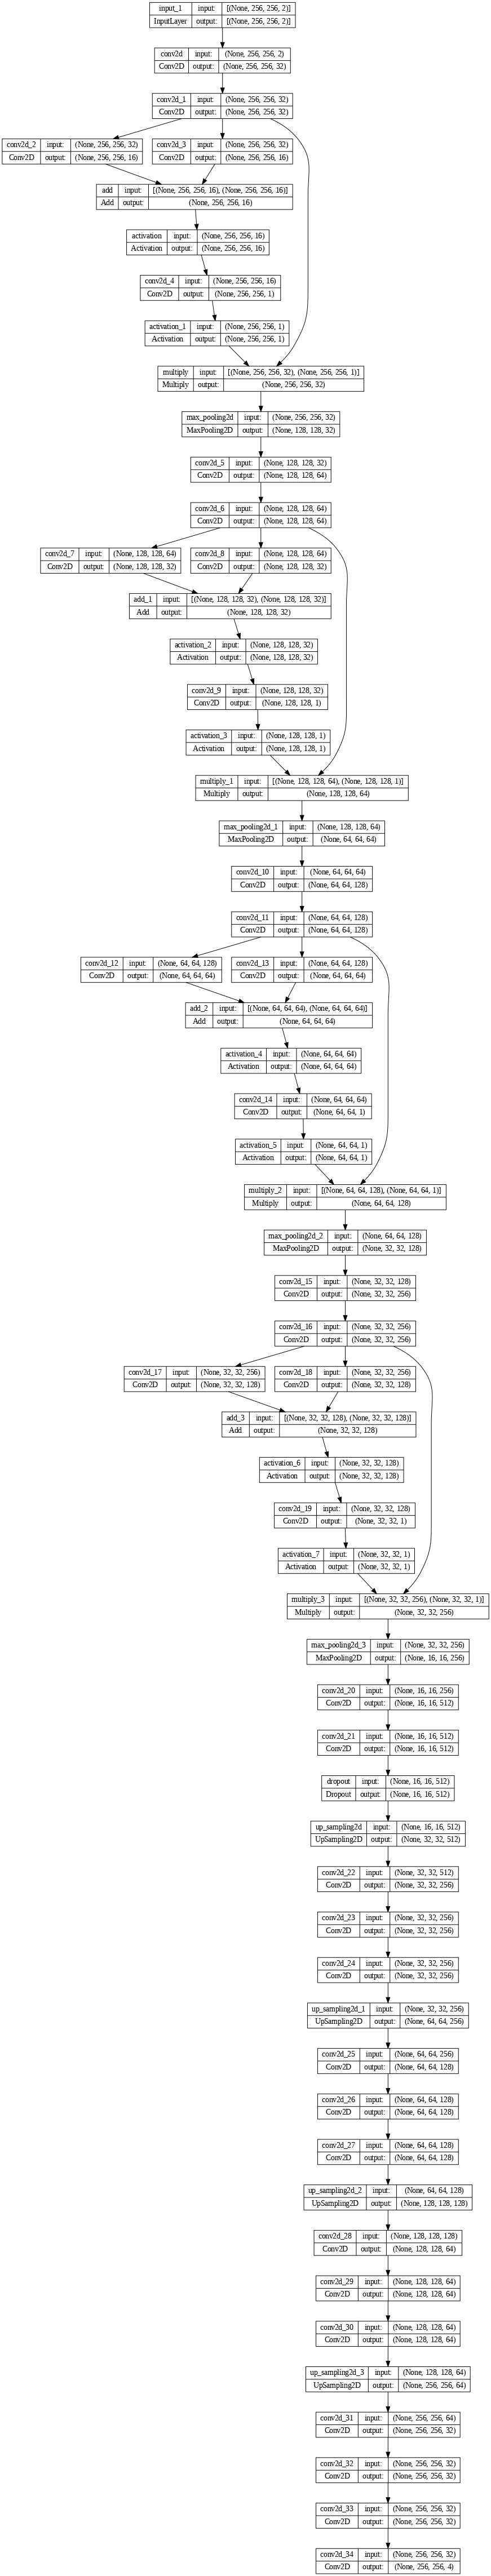

In [18]:
plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 2)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         608       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 256, 256, 16)         528       ['conv2d_1[0][0]']            
                                                                                              

# Spliting test and train data

In [20]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
#train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);


train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [21]:
train_and_test_ids[0]

'Brats18_CBICA_AQA_1'

In [22]:
train_ids[0]

'Brats18_TCIA04_328_1'

# Definition of Data generator class

In [23]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [24]:
# class DataGenerator(tf.keras.utils.Sequence):
#     'Generates data for Keras'
#     def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
#         'Initialization'
#         self.dim = dim
#         self.batch_size = batch_size
#         self.list_IDs = list_IDs
#         self.n_channels = n_channels
#         self.shuffle = shuffle
#         self.on_epoch_end()

#     def __len__(self):
#         'Denotes the number of batches per epoch'
#         return len(self.list_IDs) // self.batch_size  # Adjusted for the possibility of partial batches

#     def __getitem__(self, index):
#         'Generate one batch of data'
#         # Generate indexes of the batch
#         indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]

#         # Find list of IDs
#         Batch_ids = [self.list_IDs[k] for k in indexes]

#         # Generate data
#         X, y = self.__data_generation(Batch_ids)

#         return X, y

#     def on_epoch_end(self):
#         'Updates indexes after each epoch'
#         self.indexes = np.arange(len(self.list_IDs))
#         if self.shuffle:
#             np.random.shuffle(self.indexes)

#     def __data_generation(self, Batch_ids):
#         'Generates data containing batch_size samples'  # X : (n_samples, *dim, n_channels)
#         # Initialization
#         X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
#         y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim))
#         Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))

#         # Generate data
#         for c, i in enumerate(Batch_ids):
#             case_path = os.path.join(TRAIN_DATASET_PATH, i)

#             data_path = os.path.join(case_path, f'{i}_flair.nii')
#             flair = nib.load(data_path).get_fdata()

#             data_path = os.path.join(case_path, f'{i}_t1ce.nii')
#             ce = nib.load(data_path).get_fdata()

#             data_path = os.path.join(case_path, f'{i}_seg.nii')
#             seg = nib.load(data_path).get_fdata()

#             for j in range(VOLUME_SLICES):
#                 X[j + VOLUME_SLICES * c, :, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
#                 X[j + VOLUME_SLICES * c, :, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

#                 y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]

#         # Generate masks
#         y[y == 4] = 3
#         mask = tf.one_hot(y, 4)
#         Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
#         return X / np.max(X), Y


# training_generator = DataGenerator(train_ids)
# valid_generator = DataGenerator(val_ids)
# test_generator = DataGenerator(test_ids)


In [25]:
print(len(train_ids))
print(len(val_ids))
print(len(test_ids))

142
42
26


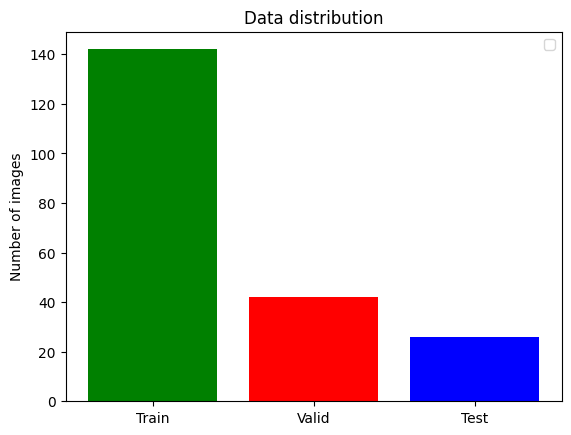

In [26]:
# show number of data for each dir
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')
    plt.savefig('data2018.png')
    plt.show()

showDataLayout()

# Training the model with callbacks¶

In [27]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath="3D-UNet-2018-weights-improvement-{epoch:02d}-{val_accuracy:.3f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

csv_logger = CSVLogger('training_2021_2D_UNet.log')

history =  model.fit(training_generator,
                    epochs=35,
                    steps_per_epoch=len(train_ids),
                    callbacks= [checkpoint, csv_logger, early_stop],
                    validation_data = valid_generator
                    )

Epoch 1/35


ResourceExhaustedError: Graph execution error:

Detected at node model/conv2d_31/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-27-f5f831e3f731>", line 11, in <cell line: 11>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/activations.py", line 306, in relu

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5395, in relu

Detected at node model/conv2d_31/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-27-f5f831e3f731>", line 11, in <cell line: 11>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/activations.py", line 306, in relu

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5395, in relu

2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[100,64,257,257] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv2d_31/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[confusion_matrix/assert_less/Assert/AssertGuard/pivot_f/_21/_53]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[100,64,257,257] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv2d_31/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_7790]

In [ ]:
model.save("model_2021_2D_UNet.h5")

# Load Trained Model

In [ ]:
history

In [ ]:
############ load trained model ################
model = tf.keras.models.load_model('model_2021_2D_UNet.h5',
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('training_2021_2D_UNet.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

# train_dice=hist['dice_coef']
# val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,3,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

# ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
# ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
# ax[2].legend()

ax[2].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[2].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[2].legend()
plt.savefig('training_result_2018.png')
plt.show()

In [ ]:
test_ids[0]

In [ ]:
TRAIN_DATASET_PATH + test_ids[0] + "/" + test_ids[0] + '_flair.nii'

# Evaluation on test set

In [ ]:
csv_logger = CSVLogger('./evaluation_50.log')
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= [csv_logger])
print("test loss, test acc:", results)

In [ ]:
# import tensorflow as tf

# # Create a simple model
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(10, activation='relu', input_shape=(784,)),
#     tf.keras.layers.Dense(10, activation='softmax')
# ])

# # Compile the model
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# # Train the model (example)
# model.fit(x_train, y_train, epochs=5)

# # Save the weights
# model.save_weights('my_model_weights.h5')


#For Streamlit

In [ ]:
# ! pip install streamlit -q

In [ ]:
# wget -q -O - ipv4.icanhazip.com

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Load trained model
model = load_model('model_2021_2D_UNet.h5',
                   custom_objects={'accuracy': tf.keras.metrics.MeanIoU(num_classes=4),
                                   "dice_coef": dice_coef,
                                   "precision": precision,
                                   "sensitivity": sensitivity,
                                   "specificity": specificity,
                                   "dice_coef_necrotic": dice_coef_necrotic,
                                   "dice_coef_edema": dice_coef_edema,
                                   "dice_coef_enhancing": dice_coef_enhancing
                                   }, compile=False)

# Function to process and predict input image
def predict_segmentation(img_path):
    # Load the image
    img = load_img(img_path, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE))
    img = img_to_array(img)
    img = img / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Predict segmentation mask
    mask = model.predict(img)[0]

    return mask

# Function to visualize the input image and prediction
def visualize_prediction(img_path, mask):
    # Load the image
    img = load_img(img_path, color_mode='grayscale')
    img = img_to_array(img) / 255.0

    # Plot the image and mask
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(img.squeeze(), cmap='gray')
    ax1.set_title('Input Image')
    ax2.imshow(mask, cmap='viridis')
    ax2.set_title('Predicted Mask')
    plt.show()

# Upload an image
uploaded_file = files.upload()

# If an image is uploaded
if len(uploaded_file) > 0:
    # Get the file path
    img_path = list(uploaded_file.keys())[0]

    # Predict segmentation mask
    mask = predict_segmentation(img_path)

    # Display the uploaded image and predicted mask
    visualize_prediction(img_path, mask)